In [1]:
#https://towardsdatascience.com/generating-new-faces-with-variational-autoencoders-d13cfcb5f0a8
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env ROCM_PATH=/opt/rocm
import tensorflow as tf
tf.test.is_built_with_rocm()
# document export HSA_OVERRIDE_GFX_VERSION=10.3.0
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: ROCM_PATH=/opt/rocm


2023-03-19 13:53:52.537886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 13:53:52.712652: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-19 13:53:54.877595: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-03-19 13:53:54.877625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diag

In [2]:
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
import keras

In [3]:
vae_model = keras.models.load_model("vae_model_celeba.h5", compile=False)
vae_decoder = keras.models.load_model("vae_decoder_celeba.h5", compile=False)
vae_encoder = keras.models.load_model("vae_encoder_celeba.h5", compile=False)

2023-03-19 13:53:55.165190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 13:53:55.174585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-03-19 13:53:55.195806: W tensorflow/c/c_api.cc:291] Operation '{name:'log_var/kernel/Assign' id:320 op device:{requested: '', assigned: ''} def:{{{node log_var/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](log_var/kernel, log_var/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either do

In [4]:
vae_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 64)   18496       ['leaky_re_lu[0][0]']      

In [5]:
import os
from glob import glob

WEIGHTS_FOLDER = './weights/'
DATA_FOLDER = './data/img_align_celeba/'

if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
  os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

In [6]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))
# prints : Total number of images : 202599


INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Total number of images : 202599
Found 202599 images belonging to 1 classes.


/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-03-19 13:54:23.695103: W tensorflow/c/c_api.cc:291] Operation '{name:'model_1/activation/Sigmoid' id:427 op device:{requested: '', assigned: ''} def:{{{node model_1/activation/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](model_1/decoder_conv_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


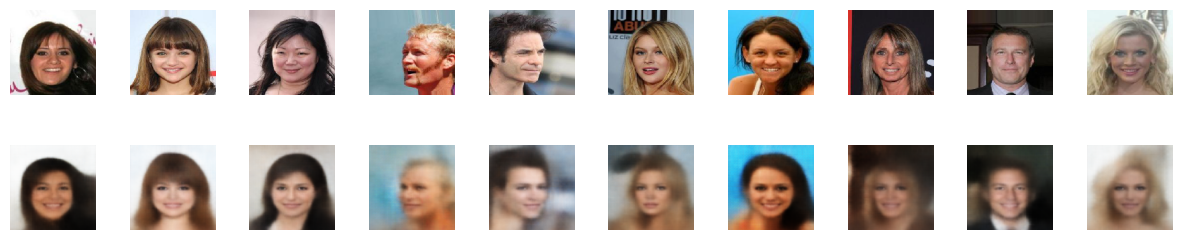

In [7]:
import matplotlib.pyplot as plt

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)  

plot_compare_vae(images = example_images)      

2023-03-19 13:54:24.405767: W tensorflow/c/c_api.cc:291] Operation '{name:'activation_1/Sigmoid' id:700 op device:{requested: '', assigned: ''} def:{{{node activation_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder_conv_3_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


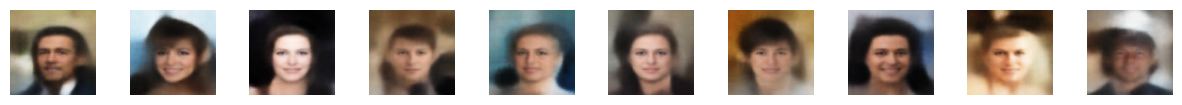

In [8]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

vae_generate_images(n_to_show=10)  